In [1]:
%load_ext autoreload
%autoreload 2

# === Standard Libraries ===
import os
import sys
import random
import json
from typing import Any

# === Scientific Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# === Signal Processing ===
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, correlate

# === Seismology Libraries ===
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# === Machine Learning Libraries ===
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === File Handling ===
import h5py

# === Custom Modules ===
module_path = os.path.abspath(os.path.join('../scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.model_selection import train_test_split
from neural_network_architectures import (
     QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d )


# === Seismology Client ===
client = Client('IRIS')

from utils import extract_waveforms
from utils import compute_spectrogram
from utils import normalize_spectrogram_minmax
from utils import return_train_val_loaders
from utils import plot_confusion_matrix_and_cr
from utils import train_model
from utils import WaveformPreprocessor


from collections import defaultdict
import json

import seisbench.models as sbm

cuda


## Loading the trained models

In [2]:
# ====================
# 1. Model Setup Parameters
# ====================
# Fixed parameters for the models (do not change)
num_channels = 3        # Number of input channels (seismic data)
dropout = 0.9           # Dropout rate to prevent overfitting

# Set device to GPU if available, else use CPU
device = "cuda"     #torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# 2. Model Initialization
# ============================
# Initialize models with the number of classes, channels, and dropout rate
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels, dropout_rate=dropout).to(device)

# ============================
# 3. Load Pretrained Weights
# ============================
# Load the pretrained model state dictionaries from saved files
saved_model_seismiccnn_2d = torch.load('../trained_models/best_model_new_augmented_SeismicCNN_2d.pth', map_location=device)
saved_model_quakexnet_2d = torch.load('../trained_models/best_model_new_augmented_QuakeXNet_2d.pth', map_location=device)
saved_model_quakexnet_1d = torch.load('../trained_models/best_model_new_augmented_QuakeXNet_1d.pth', map_location=device)
saved_model_seismiccnn_1d = torch.load('../trained_models/best_model_new_augmented_SeismicCNN_1d.pth', map_location=device)

# ============================
# 4. Load Weights into Models
# ============================
# Load the state dictionaries into the corresponding models
model_seismiccnn_1d.load_state_dict(saved_model_seismiccnn_1d)
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_quakexnet_1d.load_state_dict(saved_model_quakexnet_1d)
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)


# ============================
# 5. Set Models to Evaluation Mode
# ============================
# Move models to evaluation mode (important for layers like dropout and batch norm)
model_seismiccnn_1d.eval()
model_seismiccnn_2d.eval()
model_quakexnet_1d.eval()
model_quakexnet_2d.eval()

# ============================
# 6. Move Models to Correct Device
# ============================
# Ensure all models are on the correct device (GPU or CPU)
model_seismiccnn_1d.to(device)
model_seismiccnn_2d.to(device)
model_quakexnet_1d.to(device)
model_quakexnet_2d.to(device)

/tmp/ipykernel_907886/3388980850.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('../trained_models/best_model_new_augmented_Seis

QuakeXNet_2d(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): Bat

In [3]:
## seisbench was run on BH and HH channels only. 
exotic = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
exotic = exotic[exotic["station_channel_code"] == "BH"]
exotic = exotic[exotic["source_type"] == "surface event"]
exotic

,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db
356,pnsn3179093,surface event,CC,BH,VALT,--,46.214,-122.189,1681.0,"bucket1$1,:3,:18001",100,2021-12-19T07:31:56.000000Z,NaN,NaN,7000.0,emergent,-2.019|1.492|-1.325
357,pnsn3179088,surface event,CC,BH,HOA,--,46.242,-122.192,1151.0,"bucket1$2,:3,:18001",100,2021-12-19T07:27:38.000000Z,NaN,NaN,7000.0,emergent,6.657|-3.429|8.158
359,pnsn3177563,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$4,:3,:18001",100,2021-12-07T09:43:06.000000Z,NaN,NaN,7000.0,emergent,-0.222|6.356|2.264
360,pnsn3177488,surface event,CC,BH,SUG,--,46.215,-122.176,1864.0,"bucket1$5,:3,:18001",100,2021-12-06T23:48:01.000000Z,NaN,NaN,7000.0,emergent,5.281|8.824|18.920
361,pnsn3177373,surface event,CC,BH,SEP,--,46.200,-122.191,2114.0,"bucket1$6,:3,:18001",100,2021-12-06T19:06:39.000000Z,NaN,NaN,7000.0,emergent,7.326|6.831|12.713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593,pnsn1447848,surface event,UW,BH,LON,--,46.751,-121.810,853.0,"bucket1$7322,:3,:18001",100,2004-12-20T12:28:50.000000Z,8000.0,impulsive,NaN,NaN,-1.936|-10.131|-4.605
7643,pnsn907303,surface event,CC,BH,STD,--,46.237,-122.224,1189.0,"bucket1$7372,:3,:18001",100,2005-02-07T09:10:56.000000Z,NaN,NaN,7000.0,impulsive,0.118|-0.895|-1.065
7647,pnsn907303,surface event,CC,BH,JRO,--,46.275,-122.218,1219.0,"bucket1$7376,:3,:18001",100,2005-02-07T09:10:59.000000Z,NaN,NaN,7000.0,impulsive,2.530|8.407|11.947
7664,pnsn1201233,surface event,CC,BH,WIFE,--,44.060,-121.817,1955.0,"bucket1$7393,:3,:18001",100,2004-11-08T10:47:38.000000Z,NaN,NaN,7000.0,impulsive,5.799|-1.771|5.948


In [4]:
event = exotic.iloc[11]
network = event["station_network_code"]
station = event["station_code"]
channel = event["station_channel_code"]
starttime = obspy.UTCDateTime(event["trace_start_time"])
print(event)

event_id                                  pnsn3173148
source_type                             surface event
station_network_code                               CC
station_channel_code                               BH
station_code                                      SEP
station_location_code                              --
station_latitude_deg                             46.2
station_longitude_deg                        -122.191
station_elevation_m                            2114.0
trace_name                       bucket1$62,:3,:18001
trace_sampling_rate_hz                            100
trace_start_time          2021-10-14T01:26:57.000000Z
trace_S_arrival_sample                            NaN
trace_S_onset                                     NaN
trace_P_arrival_sample                         7000.0
trace_P_onset                                emergent
trace_snr_db                      4.385|-4.590|-3.941
Name: 417, dtype: object


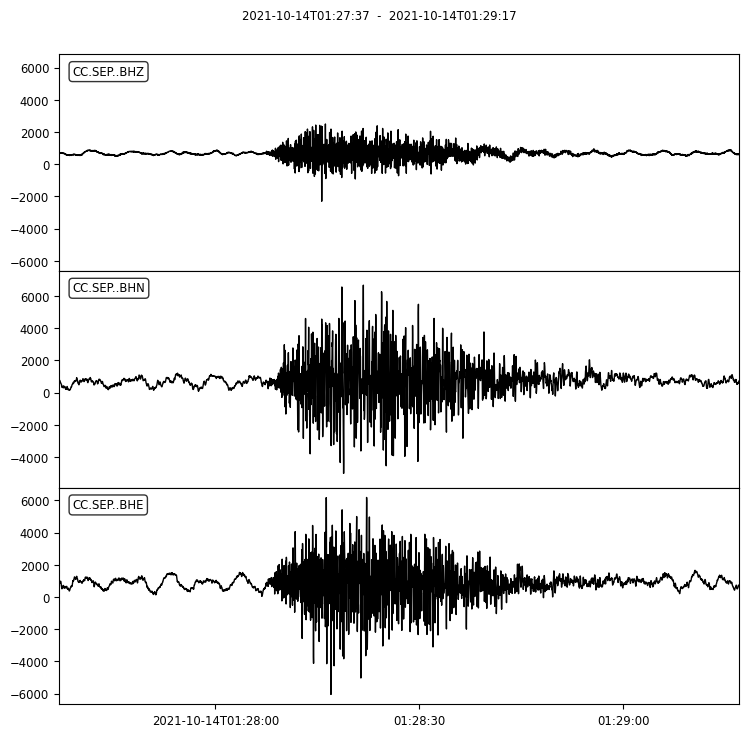

In [32]:
## Downloading the data 
st = client.get_waveforms(network=network, station=station, channel=f"{channel}?", location="--",
                         starttime=starttime + 40, endtime=starttime+ 140)



st.plot();

In [33]:
st

3 Trace(s) in Stream:
CC.SEP..BHE | 2021-10-14T01:27:37.000000Z - 2021-10-14T01:29:17.000000Z | 50.0 Hz, 5001 samples
CC.SEP..BHN | 2021-10-14T01:27:37.000000Z - 2021-10-14T01:29:17.000000Z | 50.0 Hz, 5001 samples
CC.SEP..BHZ | 2021-10-14T01:27:37.000000Z - 2021-10-14T01:29:17.000000Z | 50.0 Hz, 5001 samples

In [34]:
model_input = torch.tensor(np.array(st), dtype = torch.float32).unsqueeze(0)

In [35]:
processor = WaveformPreprocessor(input_fs = 50, target_fs = 50, lowcut = 1, highcut = 20, order = 4, taper_alpha = 0.1)

In [36]:
detrended_local = processor._linear_detrend(model_input)
tapered_local = processor._taper_tukey(detrended_local)
filtered_local = processor._bandpass_filter(tapered_local, 50, 1, 20, 4)
resampled_local = processor._resample(filtered_local, 50, 50)
normalized_local = processor._normalize_per_trace(resampled_local)

In [37]:
detrended_seisbench = torch.load('../seisbench_output/detrended_seisbench.pt')
tapered_seisbench = torch.load('../seisbench_output/tapered_seisbench.pt')
filtered_seisbench = torch.load('../seisbench_output/filtered_seisbench.pt')
resampled_seisbench = torch.load('../seisbench_output/resampled_seisbench.pt')
normalized_seisbench = torch.load('../seisbench_output/normalized_seisbench.pt')

/tmp/ipykernel_907886/2475986498.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  detrended_seisbench = torch.load('../seisbench_output/detrended_seisbench.pt')
/tmp/ipyk

## Comparing the detrended waveforms

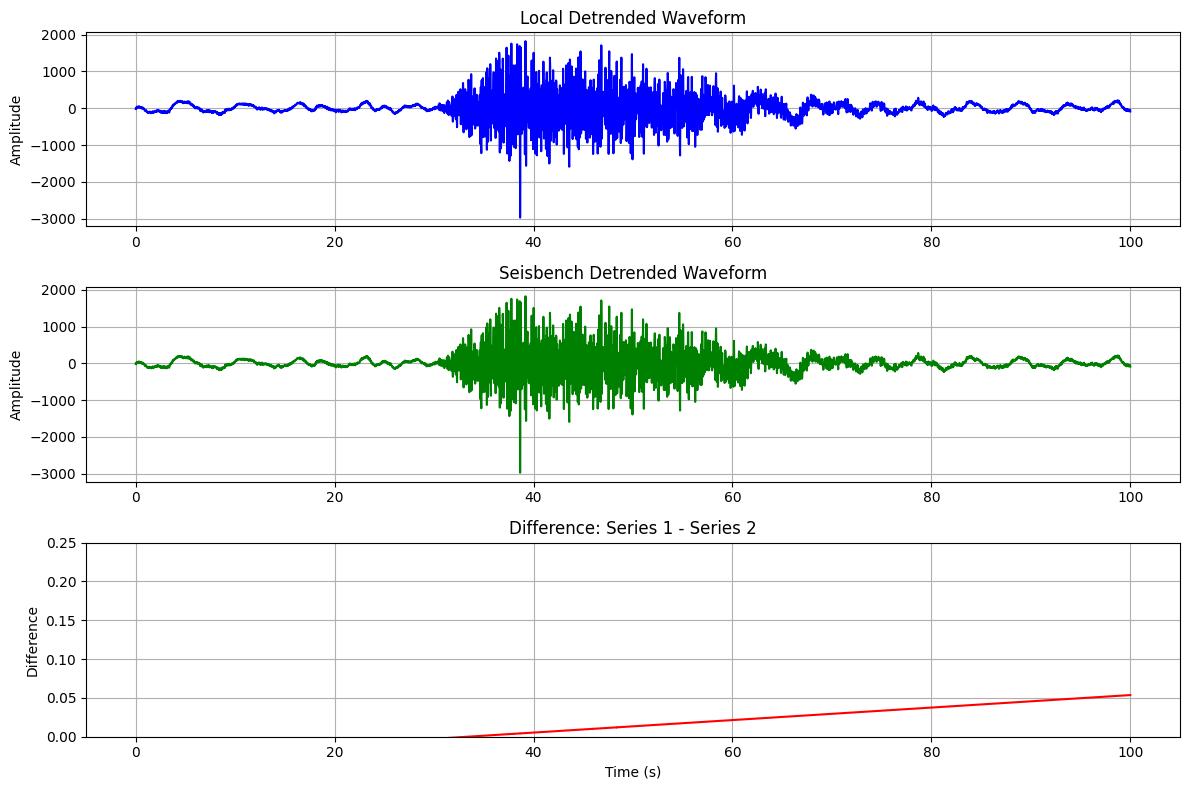

In [38]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = detrended_local.cpu()[0][2][0:5000]
series2 = detrended_seisbench.cpu()[0][2][0:5000]

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Detrended Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Detrended Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Detrended Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)
plt.ylim(0,0.25)

plt.tight_layout()
plt.show()


## Comparing the tapered waveforms

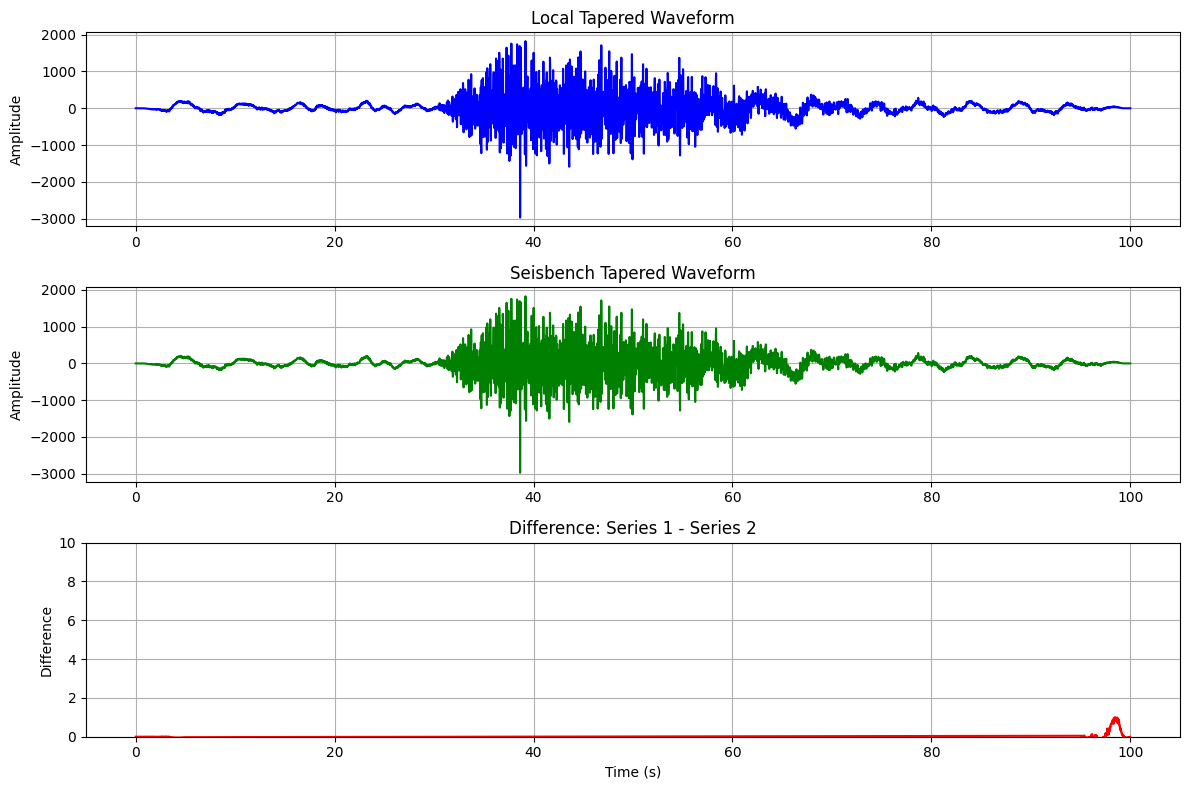

In [39]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = tapered_local.cpu()[0][2][0:5000]
series2 = tapered_seisbench.cpu()[0][2][0:5000]

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Tapered Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Tapered Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)
plt.ylim(0,10)

plt.tight_layout()
plt.show()


## Comparing filtered waveforms

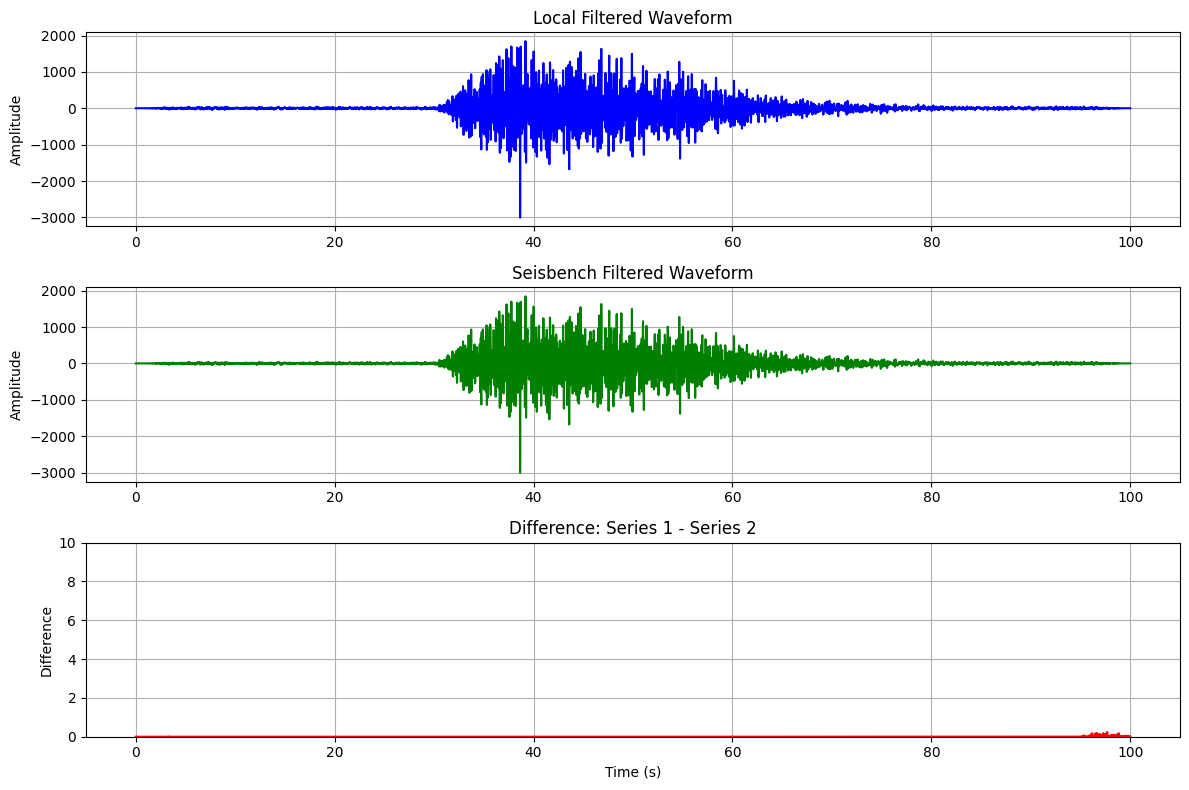

In [40]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = filtered_local.cpu()[0][2][0:5000]
series2 = filtered_seisbench.cpu()[0][2][0:5000]

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Filtered Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Filtered Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)
plt.ylim(0,10)

plt.tight_layout()
plt.show()


## Comparing normalized waveforms

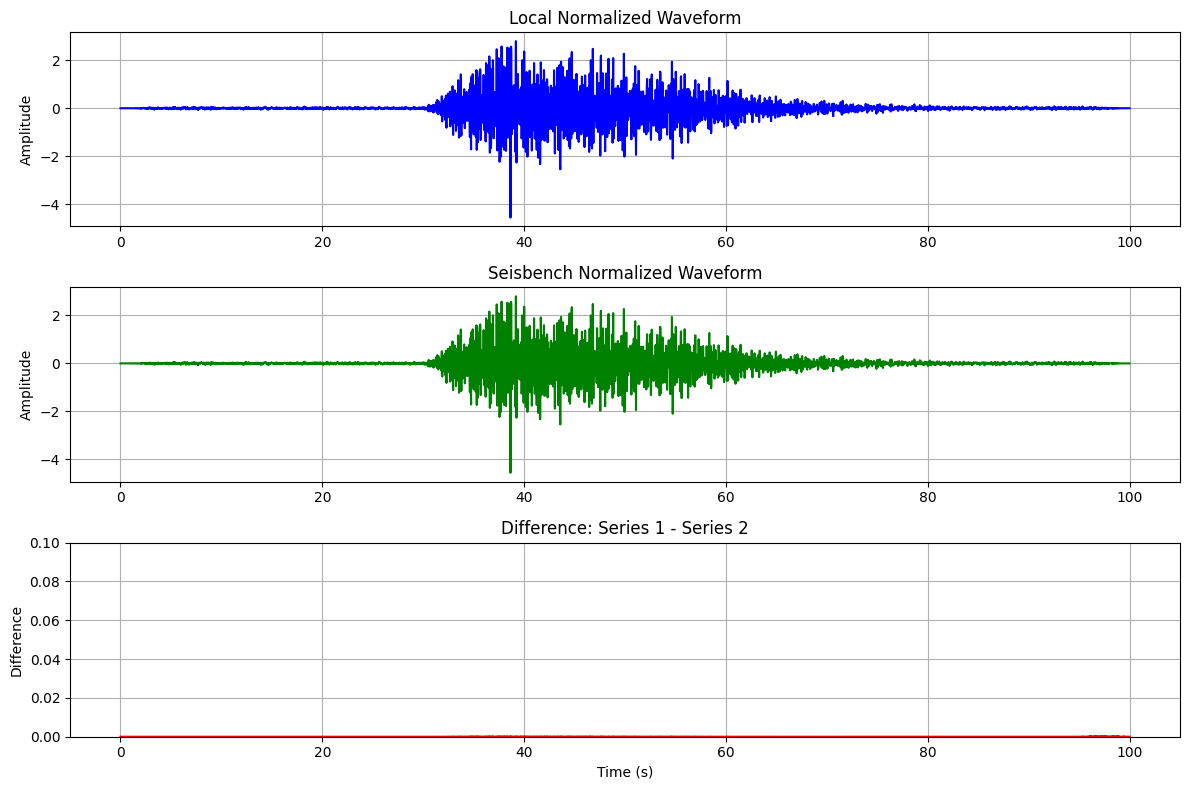

In [41]:
# Example time series
t = np.linspace(0, 100, 5000)  # 10 seconds, 500 samples
series1 = normalized_local.cpu()[0][2][0:5000]
series2 = normalized_seisbench.cpu()[0][2][0:5000]

# Difference
diff = series1 - series2

# Plot
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, series1, label="Local Tapered Waveforms", color='blue')
plt.ylabel("Amplitude")
plt.title("Local Normalized Waveform")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, series2, label="Seisbench Tapered Waveforms", color='green')
plt.ylabel("Amplitude")
plt.title("Seisbench Normalized Waveform")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, diff, label="Difference", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Difference")
plt.title("Difference: Series 1 - Series 2")
plt.grid(True)
plt.ylim(0,0.1)

plt.tight_layout()
plt.show()


## Comparing the spectrograms

In [42]:
spec_local = compute_spectrogram(normalized_local, 50)
norm_spec_local = normalize_spectrogram_minmax(spec_local[0])

spec_seisbench  = torch.load('../seisbench_output/spectrogram_seisbench.pt')
norm_spec_seisbench = torch.load('../seisbench_output/normalized_spectrogram_seisbench.pt')

/tmp/ipykernel_907886/3730592581.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spec_seisbench  = torch.load('../seisbench_output/spectrogram_seisbench.pt')
/tmp/ipyker

In [43]:
spec_local[0].shape

torch.Size([1, 3, 129, 38])

## Local Spectrogram

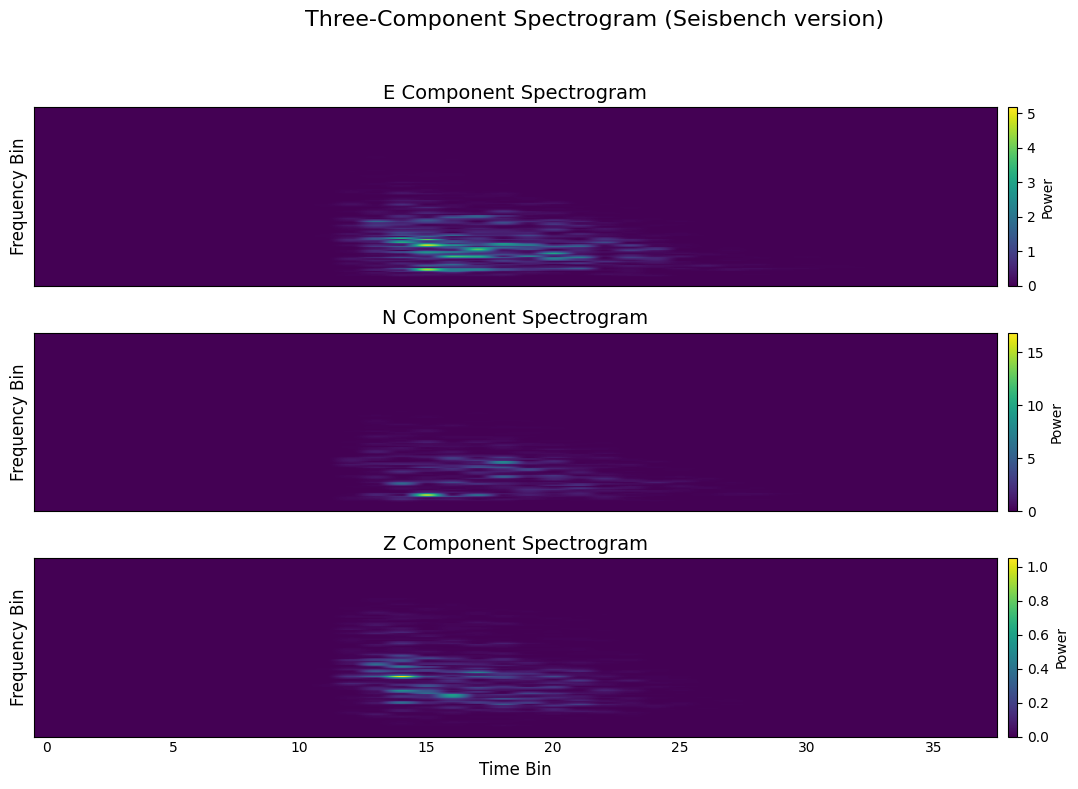

In [44]:
# Convert the processed waveforms to spectrograms
spectrogram = spec_local[0][0].cpu()



components = ['E', 'N', 'Z']

plt.figure(figsize=(12, 8))

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    im = ax.imshow(
        spectrogram[i],
        aspect='auto',
        #interpolation = 'nearest',
        origin='lower',
        cmap='viridis'
    )
    ax.set_title(f"{components[i]} Component Spectrogram", fontsize=14)
    ax.set_ylabel("Frequency Bin", fontsize=12)

    # remove grid lines
    ax.grid(False)                 # turn off the grid
    ax.tick_params(axis='both', length=0)  # hide tick marks
    ax.set_yticks([])              # comment out if you still want y-tick labels

    plt.colorbar(im, ax=ax, label='Power', pad=0.01)

    if i == 2:
        ax.set_xlabel("Time Bin", fontsize=12)
    else:
        ax.set_xticks([])

plt.suptitle("Three-Component Spectrogram (Seisbench version)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Seisbench spectrogram

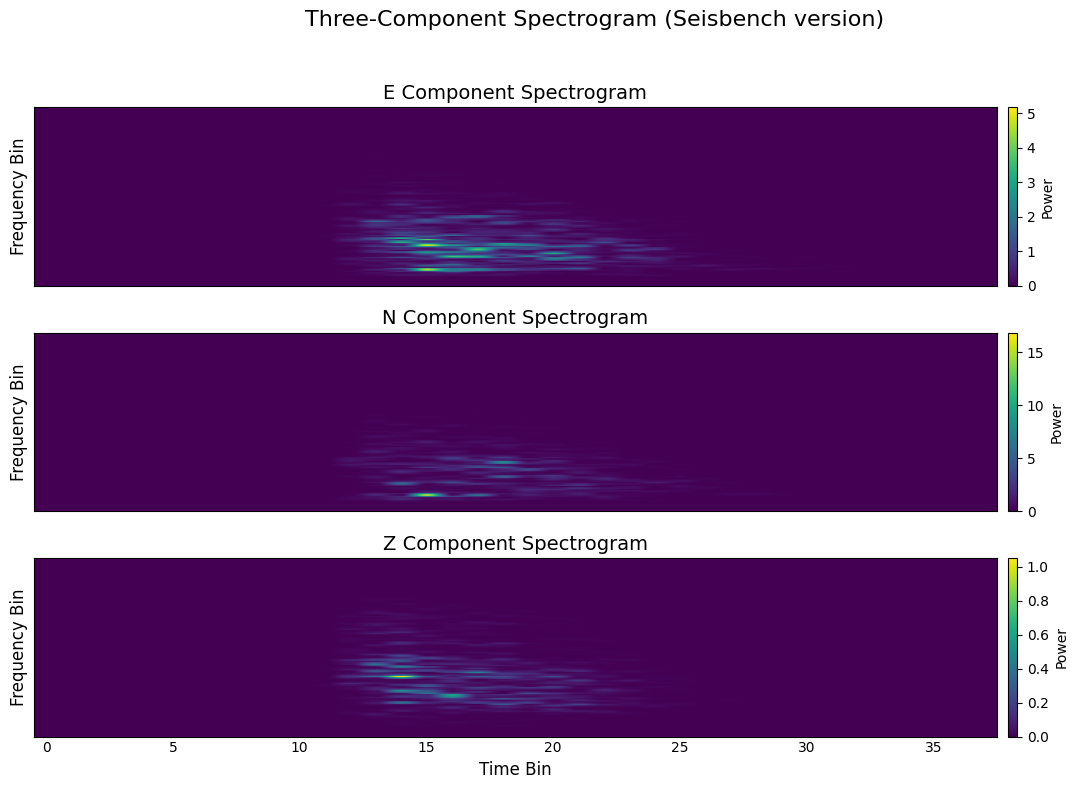

In [45]:
# Convert the processed waveforms to spectrograms
spectrogram = spec_seisbench[0][0].cpu()



components = ['E', 'N', 'Z']

plt.figure(figsize=(12, 8))

for i in range(3):
    ax = plt.subplot(3, 1, i + 1)
    im = ax.imshow(
        spectrogram[i],
        aspect='auto',
        #interpolation = 'nearest',
        origin='lower',
        cmap='viridis'
    )
    ax.set_title(f"{components[i]} Component Spectrogram", fontsize=14)
    ax.set_ylabel("Frequency Bin", fontsize=12)

    # remove grid lines
    ax.grid(False)                 # turn off the grid
    ax.tick_params(axis='both', length=0)  # hide tick marks
    ax.set_yticks([])              # comment out if you still want y-tick labels

    plt.colorbar(im, ax=ax, label='Power', pad=0.01)

    if i == 2:
        ax.set_xlabel("Time Bin", fontsize=12)
    else:
        ax.set_xticks([])

plt.suptitle("Three-Component Spectrogram (Seisbench version)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Comparing the above spectrograms

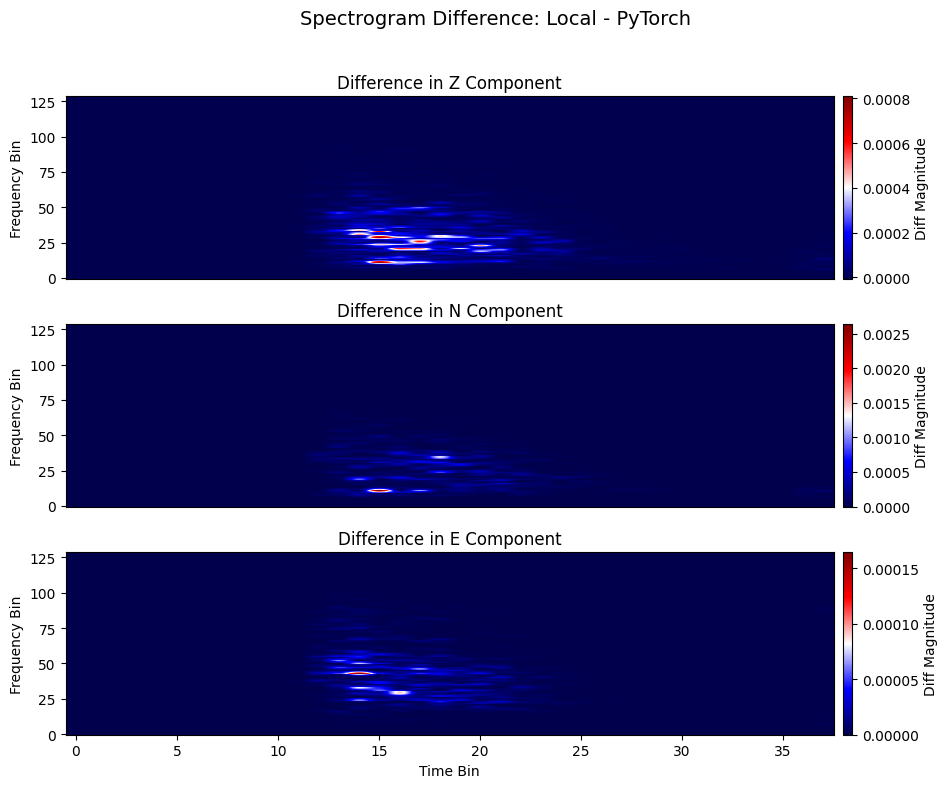

In [46]:
# Assume these are torch.Tensors, convert to numpy arrays
diff = (spec_local[0][0] - spec_seisbench[0][0]).cpu() # shape: (3, 129, 38)

components = ['Z', 'N', 'E']

plt.figure(figsize=(10, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(diff[i], aspect='auto', origin='lower', cmap='seismic')
    plt.title(f"Difference in {components[i]} Component")
    plt.ylabel("Frequency Bin")
    if i == 2:
        plt.xlabel("Time Bin")
    else:
        plt.xticks([])
    plt.colorbar(label='Diff Magnitude', pad=0.01)

plt.suptitle("Spectrogram Difference: Local - PyTorch", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Comparing the normalized spectrograms

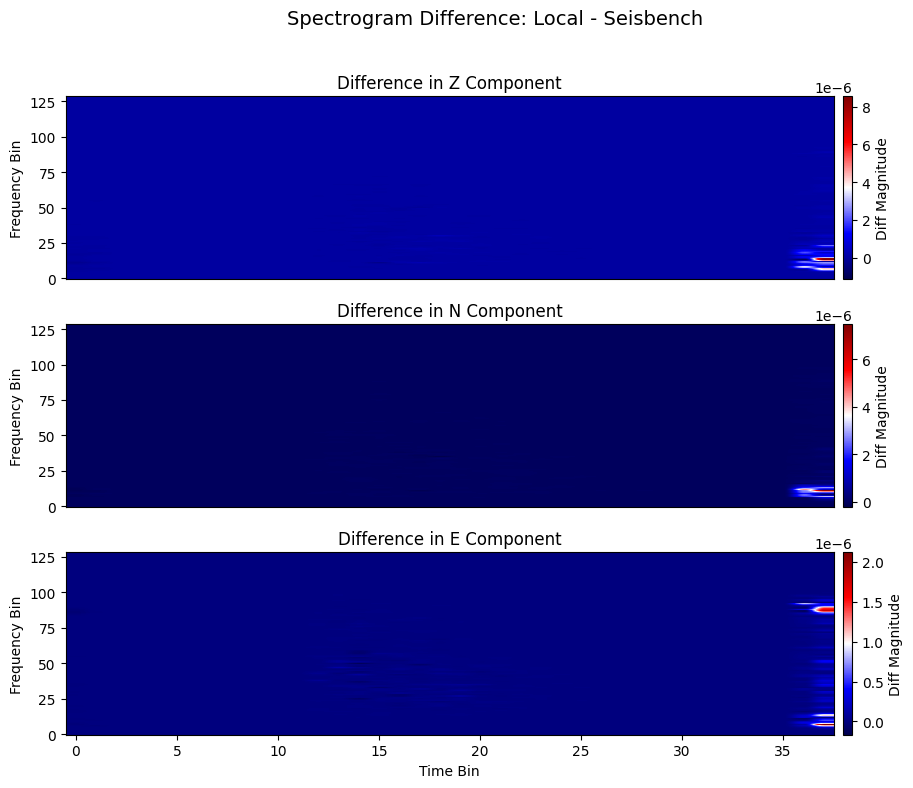

In [47]:
# Assume these are torch.Tensors, convert to numpy arrays
diff = (norm_spec_local - norm_spec_seisbench)[0].cpu() # shape: (3, 129, 38)

components = ['Z', 'N', 'E']

plt.figure(figsize=(10, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(diff[i], aspect='auto', origin='lower', cmap='seismic')
    plt.title(f"Difference in {components[i]} Component")
    plt.ylabel("Frequency Bin")
    if i == 2:
        plt.xlabel("Time Bin")
    else:
        plt.xticks([])
    plt.colorbar(label='Diff Magnitude', pad=0.01)

plt.suptitle("Spectrogram Difference: Local - Seisbench", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Testing both implementations on the common test dataset

Here we are selecting only "n" number of events per class. 


In [160]:
# Your data
test_ids = np.load('../../data/common_test_data_id.npy', allow_pickle=True)
test_waveforms = np.load('../../data/common_test_data_for_deep_learning.npy', allow_pickle=True)
test_labels = np.load('../../data/common_test_data_labels_for_deep_learning.npy', allow_pickle=True)

# Number of samples per class
n = 2000

# Collect indices per class
class_indices = defaultdict(list)
for idx, label in enumerate(test_labels):
    class_indices[label].append(idx)

# Now select n samples per class
selected_indices = []
for label, indices in class_indices.items():
    np.random.shuffle(indices)  # shuffle to randomize
    selected_indices.extend(indices[:n])  # take first n

# Final subsets
selected_waveforms = test_waveforms[selected_indices]
selected_labels = test_labels[selected_indices]
selected_ids = test_ids[selected_indices]

print(f"Selected shape: {selected_waveforms.shape}, labels: {np.unique(selected_labels, return_counts=True)}")


Selected shape: (7750, 3, 5000), labels: (array([0, 1, 2, 3]), array([2000, 1750, 2000, 2000]))


In [161]:
processor = WaveformPreprocessor(input_fs = 50, target_fs = 50, lowcut = 1, highcut = 20, order = 4, taper_alpha = 0.1)
probs_all = []
for i in tqdm(range(len(selected_waveforms))):
    waveform_np = selected_waveforms[i]  # (C, T) as NumPy array
    waveform_tensor = torch.tensor(waveform_np, dtype=torch.float32)  # Convert to PyTorch tensor
    processed = processor(waveform_tensor)  # Calls your WaveformPreprocessor
    processed = processed.unsqueeze(0)  # Add batch dimension if needed
    spec_local = compute_spectrogram(processed, 50)
    inputs = normalize_spectrogram_minmax(spec_local[0])

    
    with torch.no_grad():
        outputs = model_seismiccnn_2d(inputs.to('cuda'))
        probs = torch.nn.functional.softmax(outputs, dim=1)
        probs_all.append(probs)

100%|██████████| 7750/7750 [03:08<00:00, 41.09it/s] 


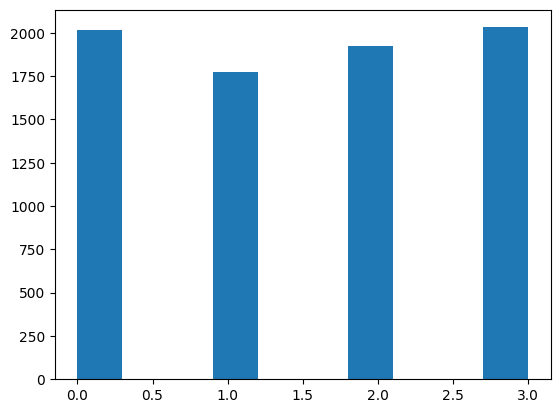

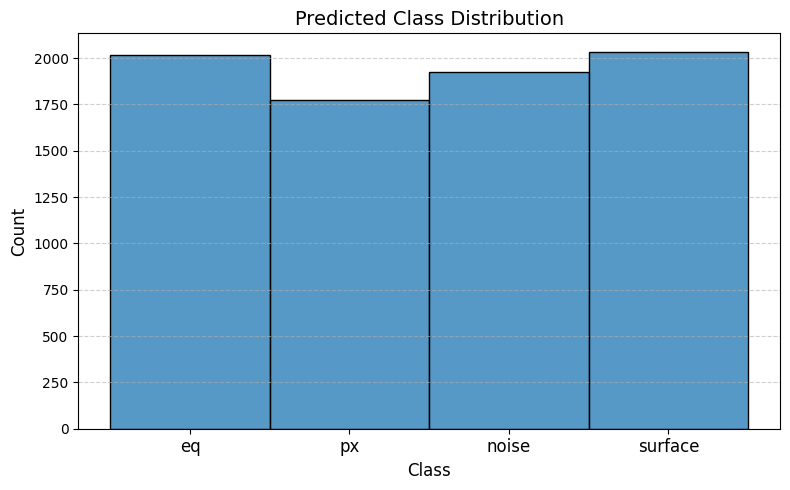

In [163]:
labels = ['eq', 'px', 'noise', 'surface']
pred_labels = [p.cpu().detach().numpy().argmax() for p in probs_all]

plt.figure(figsize=(8, 5))
sns.histplot(pred_labels, bins=len(labels), kde=False, discrete=True)
plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=12)
plt.title("Predicted Class Distribution", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


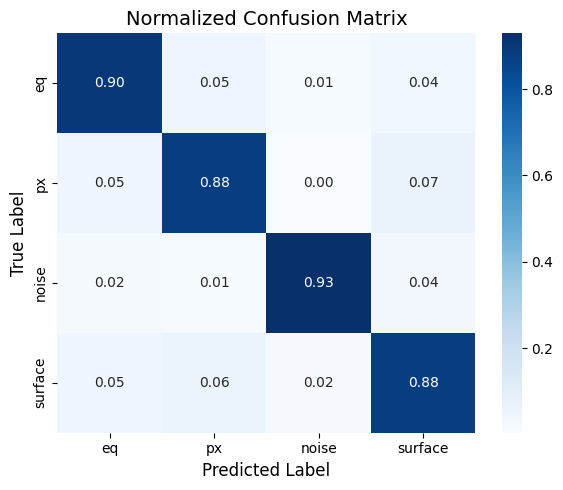

In [164]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = selected_labels  # assuming selected_labels are ground truth
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


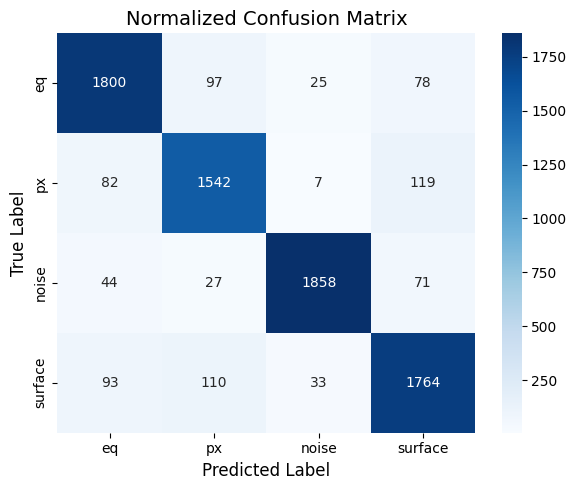

In [165]:
true_labels = selected_labels  # assuming selected_labels are ground truth
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".0f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

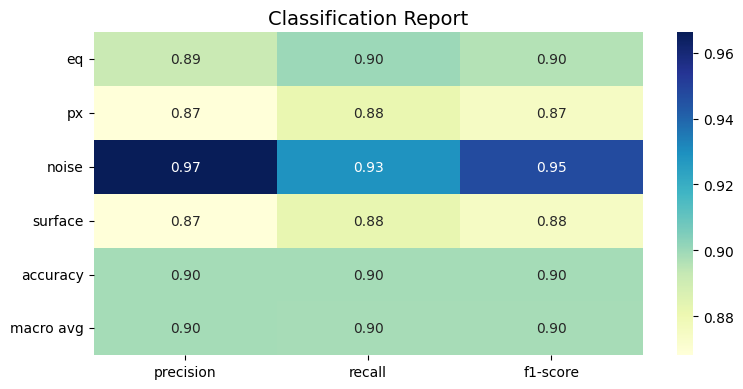

In [166]:
report = classification_report(true_labels, pred_labels, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Classification Report", fontsize=14)
plt.tight_layout()
plt.show()


### Ok seems like the new implementation is working pretty well, however to compare with the results from seisbench ecosystem, we may have to manually download the waveforms and then compare the results. 

## Testing on events from the catalog with manual download

In [218]:
# Helper function to load and filter metadata
def load_filtered_metadata(path, channel="BH", source_type=None):
    df = pd.read_csv(path)
    df = df[df["station_channel_code"] == channel]
    if source_type:
        df = df[df["source_type"] == source_type]
    return df

# Paths
base_path = "/data/whd01/yiyu_data/PNWML"
exotic_path = f"{base_path}/exotic_metadata.csv"
noise_path = f"{base_path}/noise_metadata.csv"
comcat_path = f"{base_path}/comcat_metadata.csv"

# Load filtered datasets
exotic = load_filtered_metadata(exotic_path, source_type="surface event")
noise = load_filtered_metadata(noise_path, source_type="noise")
comcat = load_filtered_metadata(comcat_path)

# Split comcat into earthquake and explosion
eq = comcat[comcat["source_type"] == "earthquake"]
exp = comcat[comcat["source_type"] == "explosion"]


noise = noise[0:200]
exotic = exotic[0:200]
eq = eq[0:200]
exp = exp[0:200]

#Now concatenate all of them into one DataFrame#
combined_df = pd.concat([noise, exotic, eq, exp], ignore_index=True)

In [224]:
# Inference config
device = 'cuda'
model = model_seismiccnn_2d
model.to(device)
model.eval()

# Storage
local_probs_new = []
local_event_ids_new = []
local_source_labels = []
# Constants
pre_event_duration = 50
post_event_duration = 100
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50


processor = WaveformPreprocessor(input_fs = 50, target_fs = 50, lowcut = 1, highcut = 20, order = 4, taper_alpha = 0.1)

for _, event in tqdm(combined_df.iterrows(), total=len(combined_df), desc="Processing events"):

    try:
        # Metadata
        network = event["station_network_code"]
        station = event["station_code"]
        channel = event["station_channel_code"]
        location = event["station_location_code"]
        event_id = event["event_id"]
        starttime = obspy.UTCDateTime(event["trace_start_time"])
       
        if event['source_type'] == 'surface event':
            pre_event_duration = 60
            post_event_duration = 160
        else:
            pre_event_duration = 40
            post_event_duration = 140
            
        # Download waveform
        stream = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            channel=f"{channel}?",
            starttime=starttime + pre_event_duration,
            endtime=starttime + post_event_duration
        )
       
        # Resample to 50 Hz
        stream.resample(sample_rate)

        waveform_np = np.array(stream)  # (C, T) as NumPy array
        waveform_tensor = torch.tensor(waveform_np, dtype=torch.float32)  # Convert to PyTorch tensor
        processed = processor(waveform_tensor)  # Calls your WaveformPreprocessor
        processed = processed.unsqueeze(0)  # Add batch dimension if needed
        spec_local = compute_spectrogram(processed, 50)
        inputs = normalize_spectrogram_minmax(spec_local[0])

        
        with torch.no_grad():
            outputs = model(inputs.to('cuda'))
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        local_probs_new.append(probs.cpu())
        local_event_ids_new.append(event_id)
        local_source_labels.append(event['source_type'])

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue

Processing events:  79%|███████▉  | 633/800 [07:00<02:02,  1.36it/s]

Failed to process event uw10582798: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 1, 129, 38] to have 3 channels, but got 1 channels instead


Processing events:  90%|█████████ | 720/800 [07:52<00:48,  1.66it/s]/tmp/ipykernel_657715/2550434032.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  waveform_np = np.array(stream)  # (C, T) as NumPy array
Processing events:  90%|█████████ | 721/800 [07:52<00:44,  1.78it/s]

Failed to process event uw10716693: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.


Processing events:  91%|█████████ | 726/800 [07:55<00:38,  1.93it/s]

Failed to process event uw10716693: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.


Processing events:  93%|█████████▎| 742/800 [08:03<00:28,  2.04it/s]

Failed to process event uw10727828: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.


Processing events:  94%|█████████▍| 750/800 [08:07<00:24,  2.07it/s]

Failed to process event uw10731883: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.


Processing events:  96%|█████████▋| 771/800 [08:19<00:16,  1.73it/s]

Failed to process event uw10723603: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.


Processing events:  96%|█████████▋| 772/800 [08:19<00:15,  1.84it/s]

Failed to process event uw10723368: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.


Processing events:  97%|█████████▋| 773/800 [08:20<00:14,  1.90it/s]

Failed to process event uw10723368: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.


Processing events:  98%|█████████▊| 786/800 [08:26<00:07,  1.91it/s]

Failed to process event uw10710408: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.


Processing events: 100%|█████████▉| 798/800 [08:33<00:01,  1.91it/s]

Failed to process event uw10718283: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.


Processing events: 100%|██████████| 800/800 [08:34<00:00,  1.56it/s]


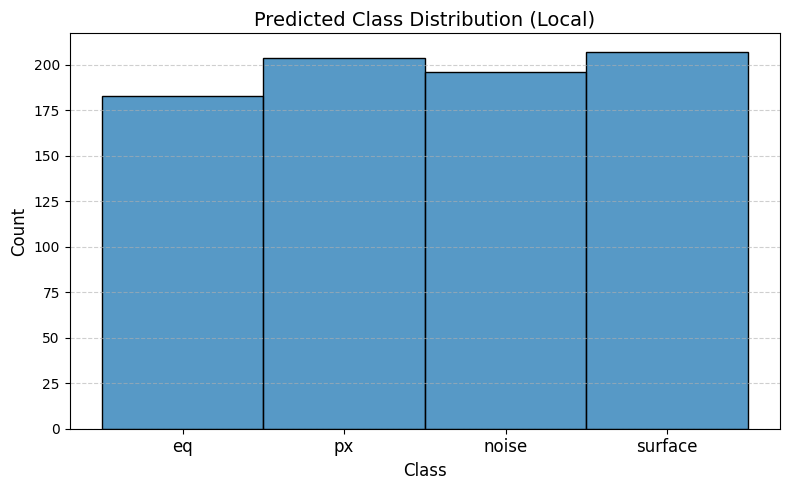

In [226]:
labels = ['eq', 'px', 'noise', 'surface']
pred_labels = [p.cpu().detach().numpy().argmax() for p in local_probs_new]

plt.figure(figsize=(8, 5))
sns.histplot(pred_labels, bins=len(labels), kde=False, discrete=True)
plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=12)
plt.title("Predicted Class Distribution (Local)", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


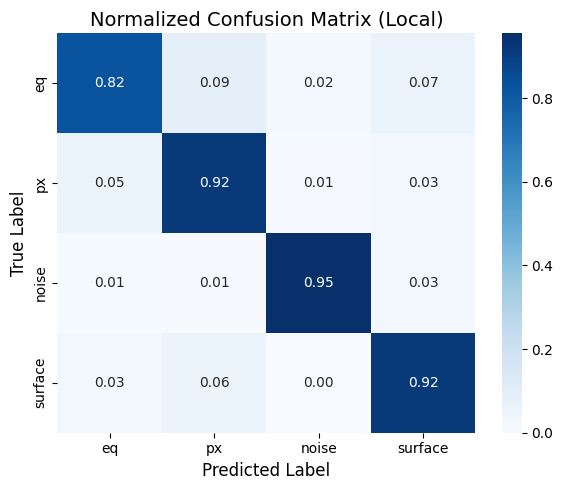

In [227]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(local_source_labels)

true_labels = numeric_labels  # assuming selected_labels are ground truth
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix (Local)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


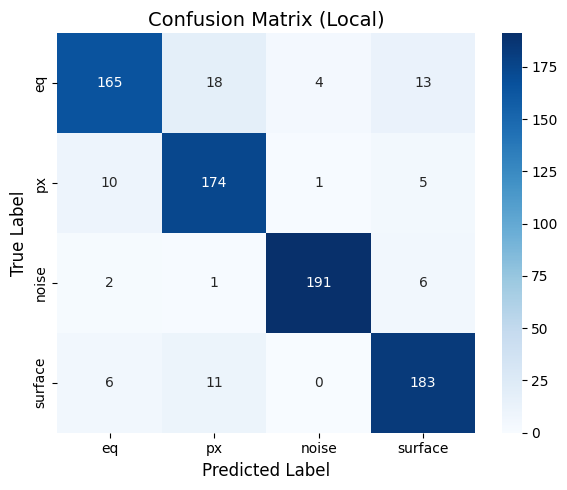

In [230]:
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(local_source_labels)

true_labels = numeric_labels  # assuming selected_labels are ground truth
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".0f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Local)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

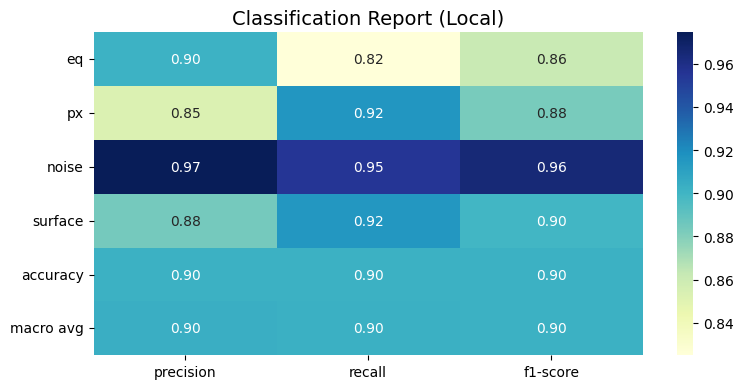

In [231]:
report = classification_report(true_labels, pred_labels, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Classification Report (Local)", fontsize=14)
plt.tight_layout()
plt.show()


## Comparing on a single day of the data

In [277]:
# Inference config
device = 'cuda'
model = model_seismiccnn_2d
model.to(device)
model.eval()

# Storage
day_probs_new = []



# Constants
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50


# Download waveform
stream = client.get_waveforms(
            network=network,
            station=station,
            location=location,
            channel=f"{channel}?",
            starttime=starttime,
            endtime=starttime + 24*3600
        )
       
# Resample to 50 Hz
stream.resample(sample_rate)

data = np.array(stream)
        
        
processor = WaveformPreprocessor(input_fs = 50, target_fs = 50, lowcut = 1, highcut = 20, order = 4, taper_alpha = 0.1)

for  i in range(0,data.shape[-1], 1000):

    try:
            
        waveform_np = data[:,i:i+5000]  # (C, T) as NumPy array
        waveform_tensor = torch.tensor(waveform_np, dtype=torch.float32)  # Convert to PyTorch tensor
        processed = processor(waveform_tensor)  # Calls your WaveformPreprocessor
        processed = processed.unsqueeze(0)  # Add batch dimension if needed
        spec_local = compute_spectrogram(processed, 50)
        inputs = normalize_spectrogram_minmax(spec_local[0])

        
        with torch.no_grad():
            outputs = model(inputs.to('cuda'))
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        day_probs_new.append(probs.cpu())

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue

Failed to process event uw10716738: mat1 and mat2 shapes cannot be multiplied (1x11520 and 15360x128)
Failed to process event uw10716738: mat1 and mat2 shapes cannot be multiplied (1x7680 and 15360x128)
Failed to process event uw10716738: mat1 and mat2 shapes cannot be multiplied (1x3840 and 15360x128)
Failed to process event uw10716738: Calculated padded input size per channel: (63 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size


In [278]:
day_probs_new

[tensor([[1.4013e-04, 7.2780e-03, 5.7617e-04, 9.9201e-01]]),
 tensor([[2.3751e-02, 9.7611e-01, 1.8109e-05, 1.1679e-04]]),
 tensor([[4.1587e-03, 9.9580e-01, 5.3201e-06, 3.5322e-05]]),
 tensor([[1.6143e-04, 2.2556e-01, 7.4723e-01, 2.7049e-02]]),
 tensor([[4.9863e-06, 2.9252e-03, 9.9693e-01, 1.3654e-04]]),
 tensor([[5.6307e-05, 9.4240e-04, 9.9816e-01, 8.4513e-04]]),
 tensor([[1.8724e-07, 3.7532e-05, 9.9970e-01, 2.6587e-04]]),
 tensor([[1.9057e-04, 2.3240e-05, 9.9925e-01, 5.3660e-04]]),
 tensor([[2.8893e-04, 1.9978e-03, 9.9762e-01, 9.1185e-05]]),
 tensor([[1.3270e-04, 1.9005e-04, 9.9866e-01, 1.0218e-03]]),
 tensor([[1.6748e-07, 4.7862e-06, 9.9998e-01, 1.1870e-05]]),
 tensor([[2.5470e-06, 6.5433e-05, 9.9981e-01, 1.2275e-04]]),
 tensor([[2.0211e-06, 2.3518e-07, 9.9994e-01, 5.9867e-05]]),
 tensor([[0.0035, 0.0023, 0.8708, 0.1235]]),
 tensor([[4.8858e-04, 3.0528e-04, 9.8330e-01, 1.5905e-02]]),
 tensor([[5.6924e-05, 5.8537e-04, 9.9913e-01, 2.2485e-04]]),
 tensor([[8.3619e-08, 3.0508e-06, 9.8793

In [281]:
day_labels = [p.cpu().detach().numpy().argmax() for p in day_probs_new]

(array([  56.,    0.,    0.,   92.,    0.,    0., 3845.,    0.,    0.,
         323.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

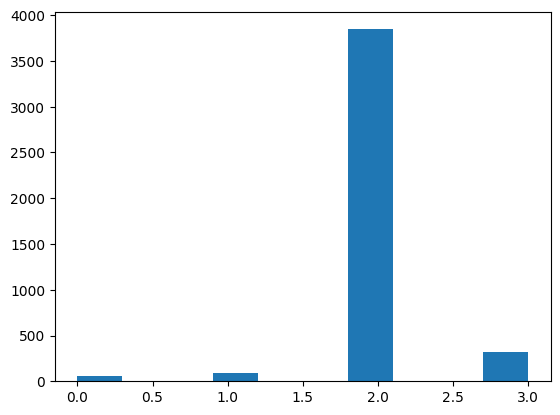

In [282]:
plt.hist(day_labels)

## Loading the seisbench day labels

In [283]:
day_probs_seisbench = obspy.read('../seisbench_output/day_probs_seisbench.mseed')

In [284]:
order_a = ["EQ0", "PX0",
           "NO0", "SU0"]

vecs = []
for ch in order_a:
    sel = day_probs_seisbench.select(channel=ch)
    if len(sel) == 0:
        raise ValueError(f"Trace with channel {ch} not found")
    vecs.append(sel[0].data)

probs_a = np.vstack(vecs).T


In [285]:
probs_a

array([[1.40155476e-04, 7.27576623e-03, 5.76387451e-04, 9.92007613e-01],
       [2.37513557e-02, 9.76113737e-01, 1.81145497e-05, 1.16863834e-04],
       [4.16111015e-03, 9.95798171e-01, 5.32285640e-06, 3.53446158e-05],
       ...,
       [5.19277319e-06, 4.69620602e-04, 9.99442995e-01, 8.22566290e-05],
       [3.41194071e-04, 3.00711207e-02, 8.29128563e-01, 1.40459105e-01],
       [3.55858612e-03, 4.36857401e-04, 9.40209866e-01, 5.57946190e-02]],
      dtype=float32)

In [286]:

# --- ecosystem B: list of tensors ------------------------------------------
probs_b = torch.vstack([p.squeeze(0) for p in day_probs_new]).numpy()

probs_b

array([[1.4013449e-04, 7.2780279e-03, 5.7617284e-04, 9.9200565e-01],
       [2.3751145e-02, 9.7611392e-01, 1.8109196e-05, 1.1678877e-04],
       [4.1586789e-03, 9.9580067e-01, 5.3201088e-06, 3.5321686e-05],
       ...,
       [5.1919396e-06, 4.6976830e-04, 9.9944264e-01, 8.2299921e-05],
       [3.4135196e-04, 3.0123014e-02, 8.2900697e-01, 1.4052871e-01],
       [3.5591563e-03, 4.3699367e-04, 9.4016236e-01, 5.5841394e-02]],
      dtype=float32)

## Comparing local and seisbench day probs

In [287]:
# arg-max labels (0-3)
labels_a = probs_a.argmax(axis=1)
labels_b = probs_b.argmax(axis=1)

accuracy = (labels_a == labels_b).mean()
print(f"Window-level agreement: {accuracy:.2%}")


Window-level agreement: 100.00%


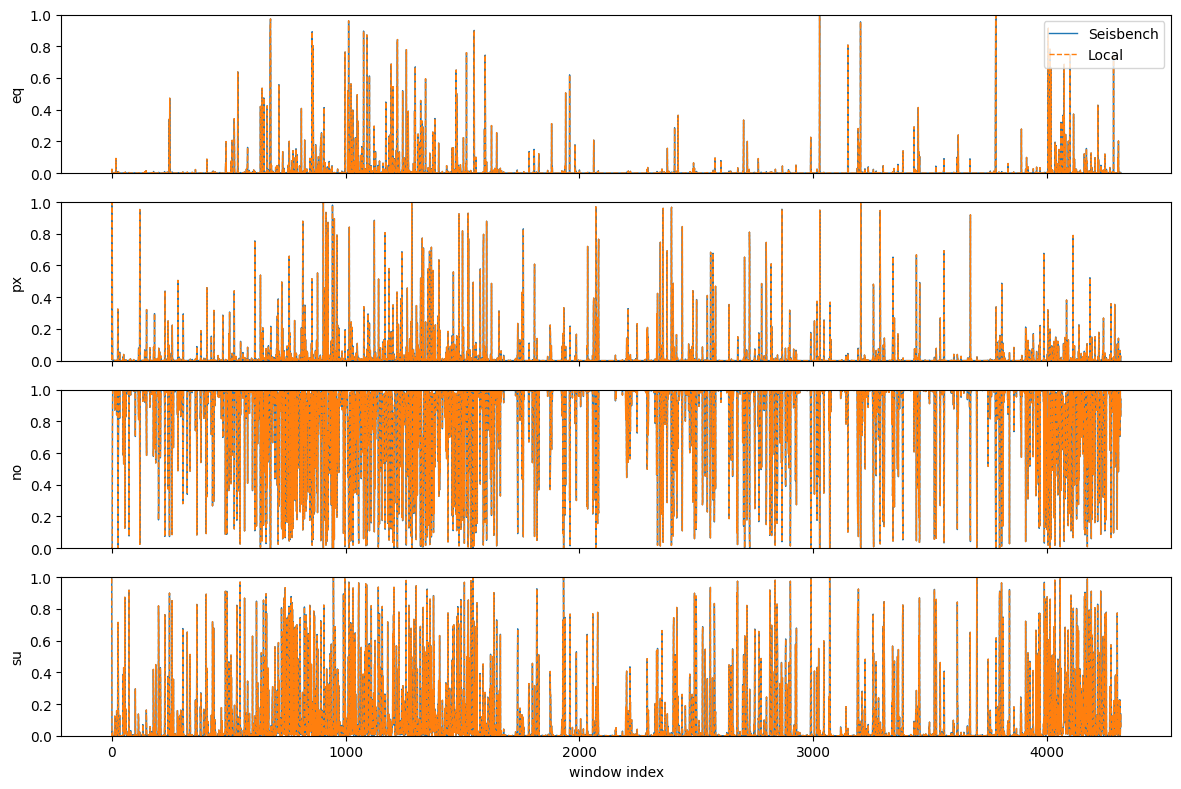

In [288]:
import matplotlib.pyplot as plt

time = np.arange(len(probs_a))    # one tick per window
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12, 8))

class_names = ["eq", "px", "no", "su"]
for k in range(4):
    ax[k].plot(time, probs_a[:, k], label="Seisbench", lw=1)
    ax[k].plot(time, probs_b[:, k], label="Local", lw=1, ls="--")
    ax[k].set_ylabel(class_names[k])
    ax[k].set_ylim(0, 1)
ax[-1].set_xlabel("window index")
ax[0].legend(loc="upper right")
plt.tight_layout()
plt.show()


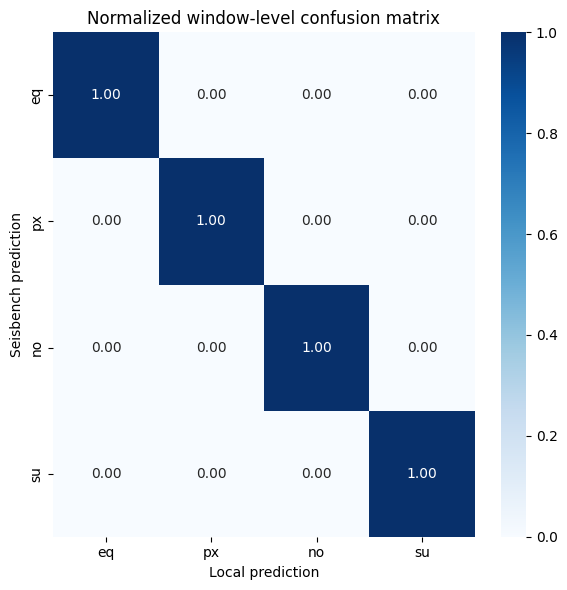

In [289]:
cm = confusion_matrix(labels_a, labels_b, labels=[0,1,2,3])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=class_names, yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Local prediction")
plt.ylabel("Seisbench prediction")
plt.title("Normalized window-level confusion matrix")
plt.tight_layout()
plt.show()


## Visualizing some detections

In [325]:
# -------------------------------------------------
# 1.  Configuration
# -------------------------------------------------
class_names = ['eq', 'px', 'noise', 'su']
noise_label = 2                   #   ← numeric “noise” code
threshold   = 0.7                # keep only P ≥ threshold

window_len  = 5_000               # samples per window
hop         = 1_000               # slide size
fs          = 50                  # Hz

# -------------------------------------------------
# 2.  Gather detections per class
# -------------------------------------------------
detections = {cls: [] for cls in class_names if cls != 'noise'}

for win_idx, (probs, lbl) in enumerate(zip(probs_b, labels_b)):
    if lbl == noise_label:           # skip noise
        continue
    if probs[lbl] < threshold:       # skip low-confidence hits
        continue

    # Convert window start sample → hour-of-day (0–24 axis)
    start_sample = win_idx * hop
    hour_of_day  = start_sample / fs / 3600.0

    cls_name = class_names[lbl]
    detections[cls_name].append(win_idx)


In [326]:
# ---------------------------------------------------------------
# Helper: plot N detections for a given class (Z-only, probs in title)
# ---------------------------------------------------------------
def plot_detections_for_class(
        cls_name,             # 'eq', 'px', or 'su'
        win_list,             # list[int]            – window indices
        data,                 # np.ndarray (3, T)    – raw 3-ch waveform
        probs_all,            # np.ndarray (n_wins, 4) or list[Tensor]
        processor,            # WaveformPreprocessor – your pipeline
        class_names=('eq', 'px', 'noise', 'su'),
        z_idx=0,              # which row in `data` is the Z component?
        fs=50,
        window_len=5_000,
        hop=1_000,
        max_plots= 10):

    if not win_list:
        print(f"No detections for class '{cls_name}'")
        return

    n_show = min(max_plots, len(win_list))
    fig, axes = plt.subplots(n_show, 1,
                             figsize=(10, 2.2 * n_show),
                             sharex=False)

    if n_show == 1:                           # keep iterable
        axes = [axes]

    for ax, win_idx in zip(axes, win_list[:n_show]):
        # --- slice raw waveform --------------------------------------------
        start, end = win_idx * hop, win_idx * hop + window_len
        waveform   = torch.tensor(data[:, start:end], dtype=torch.float32)

        # --- preprocess and keep only Z component --------------------------
        z_proc = processor(waveform).numpy()[z_idx]      # shape (window_len,)

        t = np.arange(window_len) / fs                   # seconds axis
        ax.plot(t, z_proc, lw=0.8)
        ax.set_ylabel('Z amp')
        ax.grid(alpha=0.3)

        # --- build probability string for title ---------------------------
        probs     = np.asarray(probs_all[win_idx]).ravel()
        prob_str  = ", ".join(f"{n}:{p:.2f}" for n, p in zip(class_names, probs))

        ax.set_title(f"{cls_name}  |  win {win_idx}  |  {start/fs/3600:.2f} h\n"
                     f"P= [{prob_str}]",
                     fontsize=9)

    fig.suptitle(f"Processed Z-channel – class '{cls_name}'", fontsize=13)
    plt.tight_layout()
    plt.show()


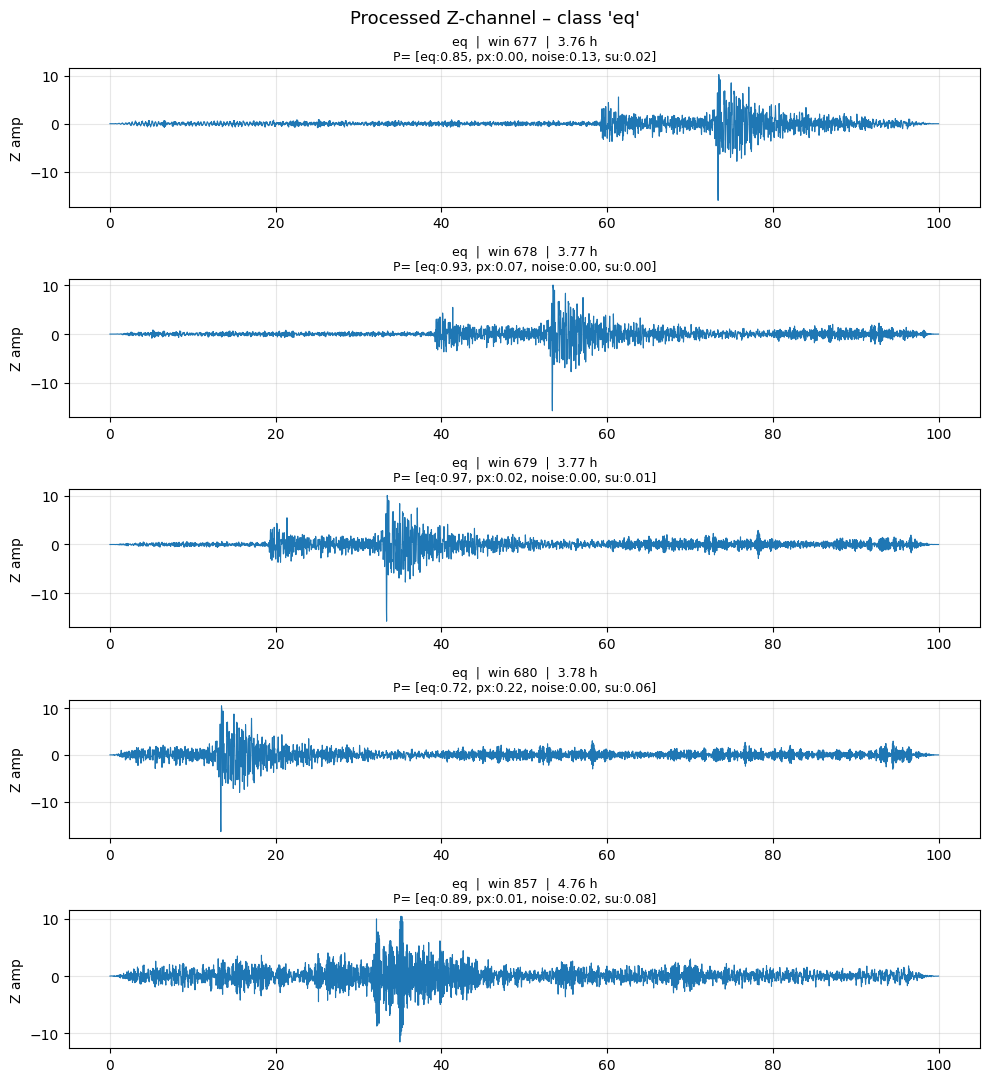

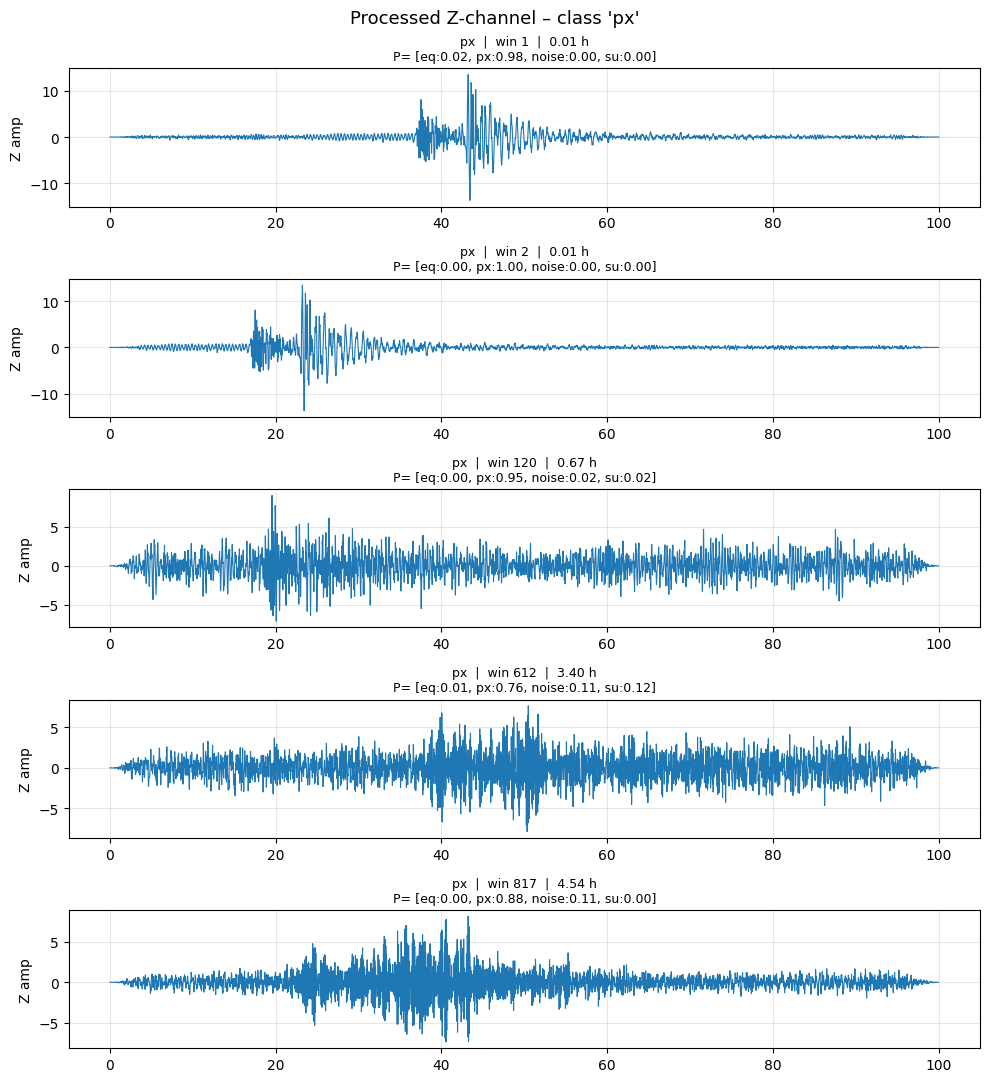

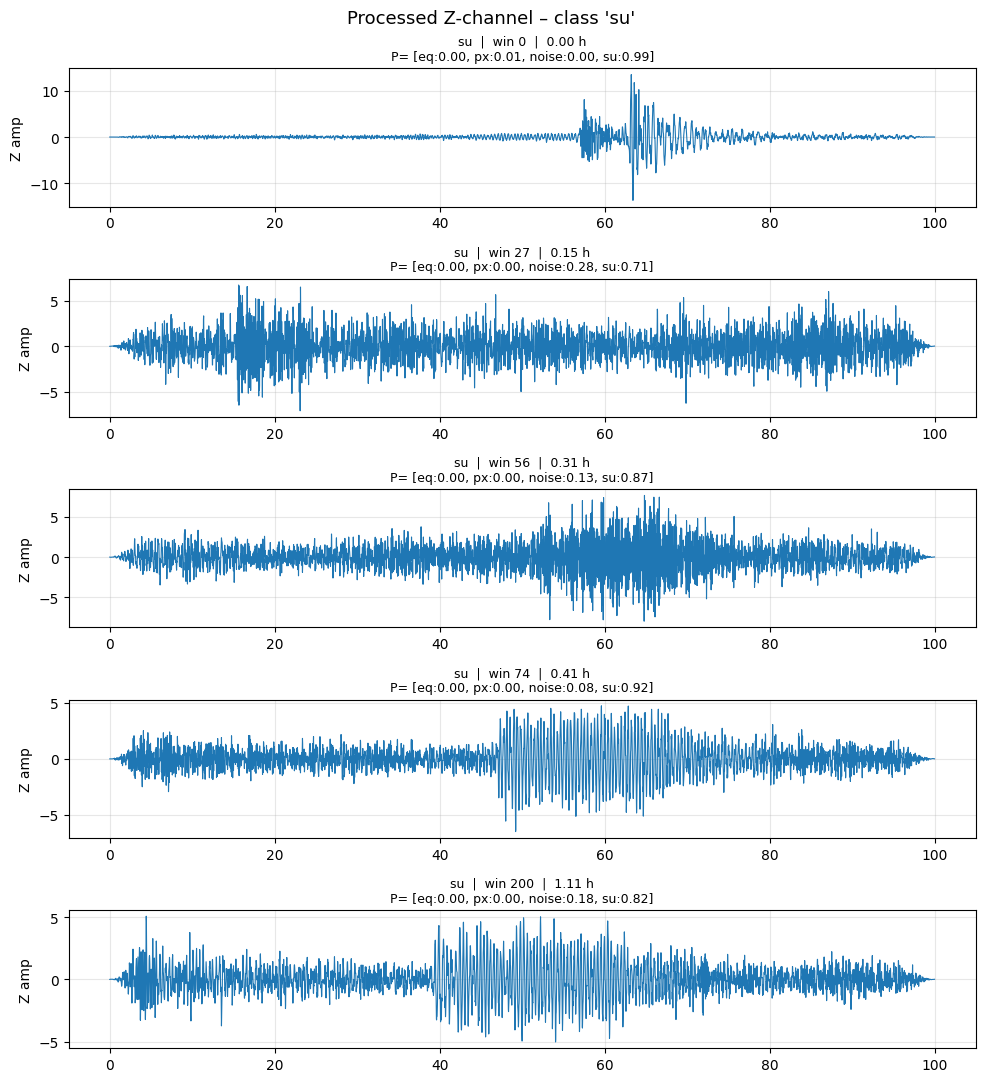

In [327]:
for cls, win_list in detections.items():        # detections from earlier
    plot_detections_for_class(cls,
                              win_list,
                              data,
                              probs_b,          # ← pass your probability array
                              processor,
                              fs=50,
                              window_len=5_000,
                              hop=1_000,
                              z_idx=0,          # change if Z is row 1 or 2
                              max_plots=5)


## Testing and comparing with a seisbench on a random surface event

In [63]:
# Inference config
device = 'cuda'
model = model_seismiccnn_2d
model.to(device)
model.eval()

# Storage
stn_probs_new = []

starttime = obspy.UTCDateTime("2021-08-02T04:14:28.000000Z")
stream = client.get_waveforms(network = "UW", station="RCM", channel="HH?", location="",
                         starttime=starttime-600, endtime=starttime+600)

# Constants
sample_rate = 50
num_samples = 5000
n_channels = 3
window_alpha = 0.1
lowcut = 1   # define these
highcut = 20
fs = 50


# Resample to 50 Hz
stream.resample(sample_rate)

data = np.array(stream)
        
        
processor = WaveformPreprocessor(input_fs = 50, target_fs = 50, lowcut = 1, highcut = 20, order = 4, taper_alpha = 0.1)

for  i in range(0,data.shape[-1], 1000):

    try:
            
        waveform_np = data[:,i:i+5000]  # (C, T) as NumPy array
        waveform_tensor = torch.tensor(waveform_np, dtype=torch.float32)  # Convert to PyTorch tensor
        processed = processor(waveform_tensor)  # Calls your WaveformPreprocessor
        processed = processed.unsqueeze(0)  # Add batch dimension if needed
        spec_local = compute_spectrogram(processed, 50)
        inputs = normalize_spectrogram_minmax(spec_local[0])

        
        with torch.no_grad():
            outputs = model(inputs.to('cuda'))
            probs = torch.nn.functional.softmax(outputs, dim=1)

        # Store results
        stn_probs_new.append(probs.cpu())

    except Exception as e:
        print(f"Failed to process event {event.get('event_id', 'unknown')}: {e}")
        continue

Failed to process event pnsn3173148: mat1 and mat2 shapes cannot be multiplied (1x11520 and 15360x128)
Failed to process event pnsn3173148: mat1 and mat2 shapes cannot be multiplied (1x7680 and 15360x128)
Failed to process event pnsn3173148: mat1 and mat2 shapes cannot be multiplied (1x3840 and 15360x128)
Failed to process event pnsn3173148: Calculated padded input size per channel: (63 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size


In [66]:
## importing the seisbench output
import pickle

with open("../seisbench_output/annotate.pt", "rb") as f:   # "rb" = read-binary
    obj = pickle.load(f)

# obj now holds whatever Python object was pickled
print(type(obj), len(obj))


<class 'obspy.core.stream.Stream'> 4


In [69]:
np.array(obj)

array([[6.27899426e-05, 1.15131671e-02, 5.87379575e-01, 8.55599821e-01,
        2.86705254e-05, 9.14831739e-03, 2.03380883e-02, 2.19157562e-02,
        4.75311965e-01, 4.39317198e-03, 3.71711479e-07, 9.90771198e-08,
        9.51616168e-01, 2.43182035e-06, 4.14071870e-08, 1.49352127e-04,
        8.82613100e-03, 5.26267812e-02, 3.32065560e-02, 6.54492644e-04,
        5.65732224e-03, 3.22929740e-01, 8.47988963e-01, 1.72851230e-07,
        7.53301308e-02, 1.41889655e-06, 5.80842254e-08, 5.96789876e-04,
        5.71476761e-03, 1.33127526e-06, 6.48511468e-06, 1.48646213e-04,
        2.07721815e-03, 2.41751040e-04, 3.74396441e-05, 1.13261694e-06,
        2.81203422e-04, 8.67477411e-06, 6.54169053e-05, 3.34180455e-04,
        3.98308598e-03, 1.99635312e-01, 4.62391938e-08, 4.07310203e-03,
        8.34056456e-03, 4.88332193e-03, 5.75866411e-03, 2.97119342e-08,
        3.97396391e-08, 1.49356688e-12, 1.81113089e-12, 4.28596657e-04,
        4.53339843e-03, 7.22963154e-01, 9.67375562e-03, 1.433014

In [72]:
# --- seisbench output from Yiyu's system --------------------------------
probs_a = np.array(obj).T

# --- ecosystem B: list of tensors ------------------------------------------
probs_b = torch.vstack([p.squeeze(0) for p in stn_probs_new]).numpy() 

In [74]:
# arg-max labels (0-3)
labels_a = probs_a.argmax(axis=1)
labels_b = probs_b.argmax(axis=1)

accuracy = (labels_a == labels_b).mean()
print(f"Window-level agreement: {accuracy:.2%}")


Window-level agreement: 85.71%


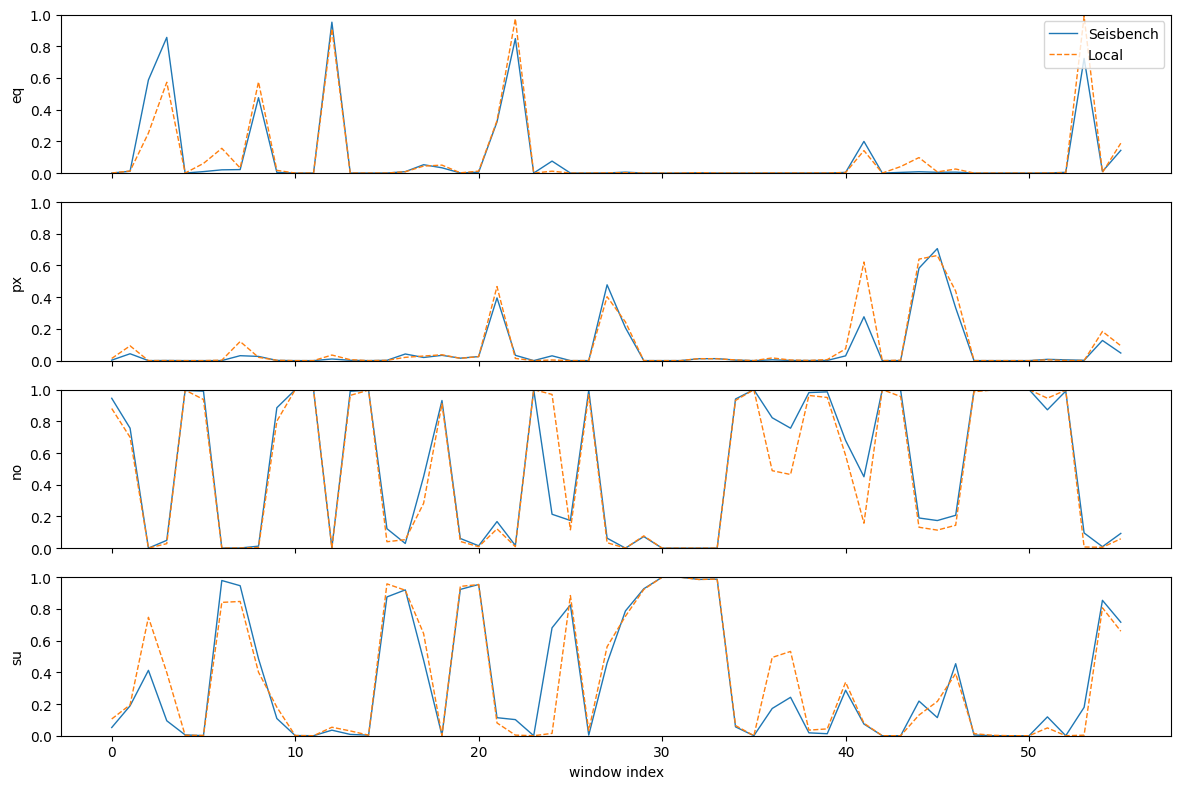

In [75]:
import matplotlib.pyplot as plt

time = np.arange(len(probs_a))    # one tick per window
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12, 8))

class_names = ["eq", "px", "no", "su"]
for k in range(4):
    ax[k].plot(time, probs_a[:, k], label="Seisbench", lw=1)
    ax[k].plot(time, probs_b[:, k], label="Local", lw=1, ls="--")
    ax[k].set_ylabel(class_names[k])
    ax[k].set_ylim(0, 1)
ax[-1].set_xlabel("window index")
ax[0].legend(loc="upper right")
plt.tight_layout()
plt.show()
